# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.98KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

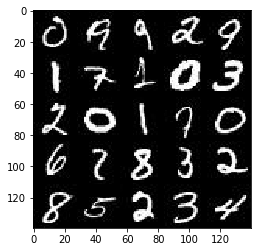

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

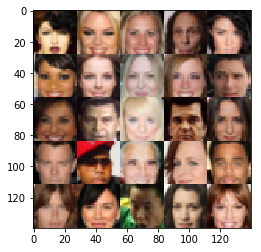

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(dtype = tf.float32, shape=(None, image_width, image_height, image_channels))
    z_input = tf.placeholder(dtype = tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(dtype = tf.float32)

    return input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
        alpha = 0.1
        x1 = tf.layers.conv2d(images, 64, 5, 
                              strides=2, 
                              padding='SAME', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 3, 
                              strides=2, 
                              padding='SAME', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        
        x3 = tf.layers.conv2d(relu2, 256, 3, 
                              strides=2, 
                              padding='SAME', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        alpha = 0.1
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        
        # Output layer
        out = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='SAME', activation = tf.nn.tanh)
        #print(out.get_shape())
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    idx = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                idx += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if idx % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                if idx % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.6585... Generator Loss: 0.0426
Epoch 1/2... Discriminator Loss: 2.6039... Generator Loss: 0.2058
Epoch 1/2... Discriminator Loss: 2.6015... Generator Loss: 0.1366
Epoch 1/2... Discriminator Loss: 2.1856... Generator Loss: 0.2351
Epoch 1/2... Discriminator Loss: 2.4402... Generator Loss: 0.1859
Epoch 1/2... Discriminator Loss: 2.2109... Generator Loss: 0.2557
Epoch 1/2... Discriminator Loss: 2.0785... Generator Loss: 0.2808
Epoch 1/2... Discriminator Loss: 1.9005... Generator Loss: 0.3897
Epoch 1/2... Discriminator Loss: 1.7590... Generator Loss: 0.4309


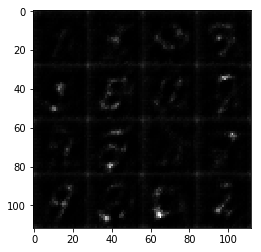

Epoch 1/2... Discriminator Loss: 1.7665... Generator Loss: 0.5153
Epoch 1/2... Discriminator Loss: 1.7325... Generator Loss: 0.4673
Epoch 1/2... Discriminator Loss: 1.8325... Generator Loss: 0.3209
Epoch 1/2... Discriminator Loss: 1.6697... Generator Loss: 0.4003
Epoch 1/2... Discriminator Loss: 1.7427... Generator Loss: 0.3517
Epoch 1/2... Discriminator Loss: 1.9793... Generator Loss: 0.2428
Epoch 1/2... Discriminator Loss: 1.4940... Generator Loss: 0.5769
Epoch 1/2... Discriminator Loss: 1.6914... Generator Loss: 0.4373
Epoch 1/2... Discriminator Loss: 1.6207... Generator Loss: 0.5412
Epoch 1/2... Discriminator Loss: 1.5946... Generator Loss: 0.4508


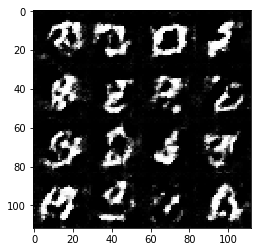

Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.9712
Epoch 1/2... Discriminator Loss: 1.5447... Generator Loss: 0.4908
Epoch 1/2... Discriminator Loss: 1.7971... Generator Loss: 0.3016
Epoch 1/2... Discriminator Loss: 2.1026... Generator Loss: 0.2141
Epoch 1/2... Discriminator Loss: 1.6729... Generator Loss: 0.4450
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.9547
Epoch 1/2... Discriminator Loss: 1.6800... Generator Loss: 0.5017
Epoch 1/2... Discriminator Loss: 1.9108... Generator Loss: 0.3881
Epoch 1/2... Discriminator Loss: 1.5874... Generator Loss: 1.2057
Epoch 1/2... Discriminator Loss: 1.6204... Generator Loss: 0.3936


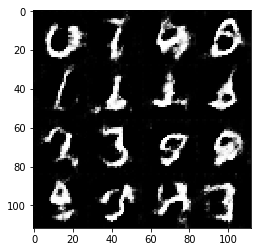

Epoch 1/2... Discriminator Loss: 1.7906... Generator Loss: 0.4384
Epoch 1/2... Discriminator Loss: 1.6449... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.6088... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 1.7691... Generator Loss: 0.4847
Epoch 1/2... Discriminator Loss: 2.2161... Generator Loss: 0.1786
Epoch 1/2... Discriminator Loss: 1.7612... Generator Loss: 0.4252
Epoch 1/2... Discriminator Loss: 1.6538... Generator Loss: 0.6243
Epoch 1/2... Discriminator Loss: 1.6295... Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 1.7930... Generator Loss: 0.3491
Epoch 1/2... Discriminator Loss: 1.5688... Generator Loss: 0.5563


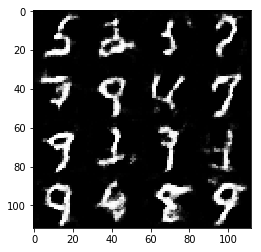

Epoch 1/2... Discriminator Loss: 1.4693... Generator Loss: 0.5715
Epoch 1/2... Discriminator Loss: 1.7275... Generator Loss: 0.3887
Epoch 1/2... Discriminator Loss: 1.7379... Generator Loss: 0.3643
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.7707... Generator Loss: 0.3638
Epoch 1/2... Discriminator Loss: 1.6491... Generator Loss: 0.4812
Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 0.4456
Epoch 1/2... Discriminator Loss: 1.5375... Generator Loss: 0.5295
Epoch 1/2... Discriminator Loss: 1.8845... Generator Loss: 0.3177
Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 0.6619


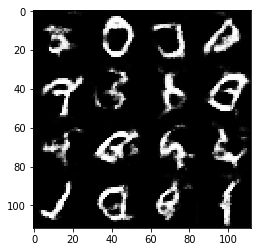

Epoch 1/2... Discriminator Loss: 1.6774... Generator Loss: 0.4968
Epoch 1/2... Discriminator Loss: 1.5767... Generator Loss: 0.5471
Epoch 1/2... Discriminator Loss: 1.7260... Generator Loss: 0.4127
Epoch 1/2... Discriminator Loss: 1.5990... Generator Loss: 0.5304
Epoch 1/2... Discriminator Loss: 1.5531... Generator Loss: 0.4904
Epoch 1/2... Discriminator Loss: 1.6371... Generator Loss: 0.3775
Epoch 1/2... Discriminator Loss: 1.5194... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.6418... Generator Loss: 0.4301
Epoch 1/2... Discriminator Loss: 1.4782... Generator Loss: 0.5366
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.6712


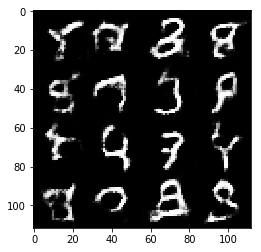

Epoch 1/2... Discriminator Loss: 1.7160... Generator Loss: 0.4133
Epoch 1/2... Discriminator Loss: 1.4873... Generator Loss: 0.5761
Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 0.7432
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 0.5816
Epoch 1/2... Discriminator Loss: 1.4988... Generator Loss: 0.5534
Epoch 1/2... Discriminator Loss: 1.7074... Generator Loss: 0.3481
Epoch 1/2... Discriminator Loss: 1.5646... Generator Loss: 0.4252


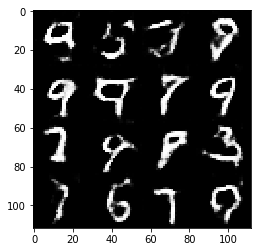

Epoch 1/2... Discriminator Loss: 1.5597... Generator Loss: 0.4123
Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 0.4268
Epoch 1/2... Discriminator Loss: 1.6249... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 1.6902... Generator Loss: 0.3693
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 1.7378... Generator Loss: 0.3610
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 1.0316
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.9212


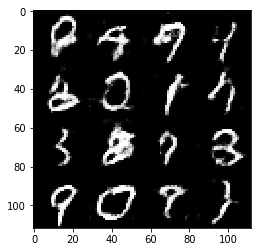

Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.7455
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 0.8432
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.5061
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.6046
Epoch 1/2... Discriminator Loss: 1.5415... Generator Loss: 0.4230
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 1.1981
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 1.4953... Generator Loss: 0.4719


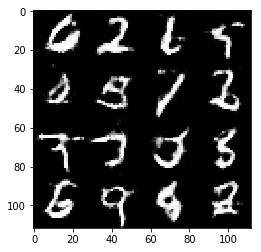

Epoch 1/2... Discriminator Loss: 1.7014... Generator Loss: 0.3464
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.4781
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.5705
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7175
Epoch 1/2... Discriminator Loss: 1.6716... Generator Loss: 0.3675
Epoch 1/2... Discriminator Loss: 1.4764... Generator Loss: 0.6631
Epoch 1/2... Discriminator Loss: 1.4104... Generator Loss: 1.2084
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.5474
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.5041... Generator Loss: 0.4333


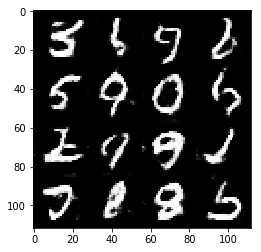

Epoch 1/2... Discriminator Loss: 1.6067... Generator Loss: 0.3724
Epoch 1/2... Discriminator Loss: 1.6575... Generator Loss: 0.3982
Epoch 1/2... Discriminator Loss: 1.6507... Generator Loss: 0.3544
Epoch 1/2... Discriminator Loss: 1.5662... Generator Loss: 0.4331
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.4607
Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 1.7273... Generator Loss: 0.3131
Epoch 1/2... Discriminator Loss: 1.5694... Generator Loss: 0.4127
Epoch 1/2... Discriminator Loss: 1.5420... Generator Loss: 0.4877
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.9466


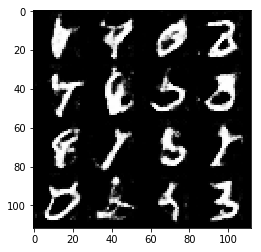

Epoch 1/2... Discriminator Loss: 1.5815... Generator Loss: 0.4251
Epoch 1/2... Discriminator Loss: 1.5837... Generator Loss: 0.4491
Epoch 1/2... Discriminator Loss: 1.5193... Generator Loss: 0.4497
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.9293
Epoch 1/2... Discriminator Loss: 1.5320... Generator Loss: 0.5985
Epoch 1/2... Discriminator Loss: 1.4365... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.6414... Generator Loss: 0.3842
Epoch 1/2... Discriminator Loss: 1.7273... Generator Loss: 0.3710
Epoch 1/2... Discriminator Loss: 1.8916... Generator Loss: 0.2722
Epoch 1/2... Discriminator Loss: 1.4917... Generator Loss: 0.5194


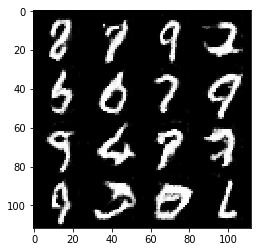

Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.4957... Generator Loss: 0.5930
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.6202
Epoch 1/2... Discriminator Loss: 1.5853... Generator Loss: 0.8623
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.5272
Epoch 1/2... Discriminator Loss: 1.6103... Generator Loss: 0.4519
Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.8906
Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.7521... Generator Loss: 0.3343


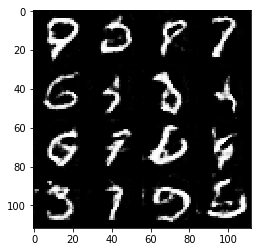

Epoch 1/2... Discriminator Loss: 1.4770... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.3552... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 1.7833... Generator Loss: 0.2967
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.5276
Epoch 1/2... Discriminator Loss: 1.6828... Generator Loss: 0.3456
Epoch 1/2... Discriminator Loss: 1.5387... Generator Loss: 0.4592
Epoch 1/2... Discriminator Loss: 1.4350... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 1.6219... Generator Loss: 0.3926
Epoch 1/2... Discriminator Loss: 1.5843... Generator Loss: 0.4486


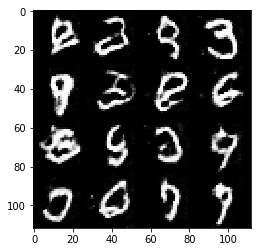

Epoch 1/2... Discriminator Loss: 1.7314... Generator Loss: 0.3167
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.5281
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.6165
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.4204
Epoch 1/2... Discriminator Loss: 1.5626... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 1.4960... Generator Loss: 0.4161
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.4802
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.6425
Epoch 1/2... Discriminator Loss: 1.7268... Generator Loss: 0.3639
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.7071


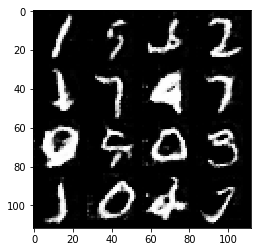

Epoch 1/2... Discriminator Loss: 1.5820... Generator Loss: 0.5500
Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.6368
Epoch 1/2... Discriminator Loss: 3.0343... Generator Loss: 0.0926
Epoch 1/2... Discriminator Loss: 1.4947... Generator Loss: 0.4867
Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.5714
Epoch 1/2... Discriminator Loss: 1.5992... Generator Loss: 0.4079


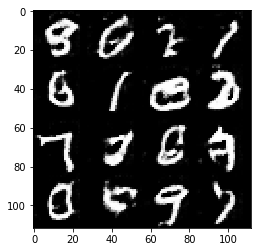

Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 0.9784
Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.4871
Epoch 1/2... Discriminator Loss: 2.3488... Generator Loss: 0.1680
Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.6492... Generator Loss: 0.4217
Epoch 1/2... Discriminator Loss: 1.7021... Generator Loss: 0.3801


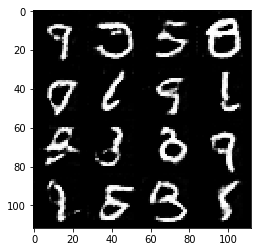

Epoch 1/2... Discriminator Loss: 1.6473... Generator Loss: 0.4133
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 1.0214
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 1.5782... Generator Loss: 0.4216
Epoch 1/2... Discriminator Loss: 1.5306... Generator Loss: 0.4461
Epoch 1/2... Discriminator Loss: 1.5182... Generator Loss: 0.5292
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.5589... Generator Loss: 0.4128


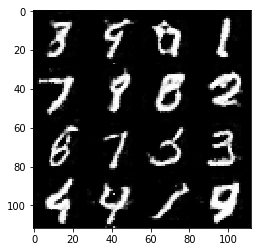

Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.5403... Generator Loss: 0.4288
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 0.6608
Epoch 1/2... Discriminator Loss: 1.6382... Generator Loss: 0.3873
Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 2.9001... Generator Loss: 2.6918
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 0.6021
Epoch 2/2... Discriminator Loss: 1.9666... Generator Loss: 0.2632


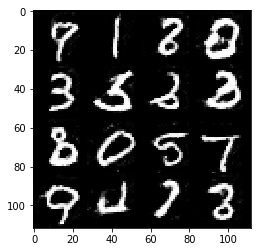

Epoch 2/2... Discriminator Loss: 1.5679... Generator Loss: 0.4465
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 1.8066... Generator Loss: 0.3092
Epoch 2/2... Discriminator Loss: 1.6219... Generator Loss: 0.4000
Epoch 2/2... Discriminator Loss: 1.7586... Generator Loss: 0.3079
Epoch 2/2... Discriminator Loss: 1.2747... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.5375
Epoch 2/2... Discriminator Loss: 1.6239... Generator Loss: 0.3897
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 0.8610


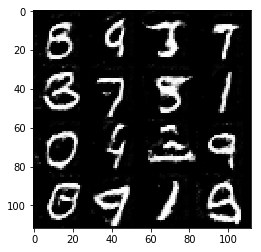

Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.7212
Epoch 2/2... Discriminator Loss: 1.6977... Generator Loss: 0.3410
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.5821
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.8365
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.6019
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.9919
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.5255
Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.5886
Epoch 2/2... Discriminator Loss: 1.4610... Generator Loss: 1.2604


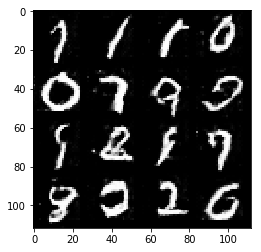

Epoch 2/2... Discriminator Loss: 1.2619... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 0.9640... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.5958
Epoch 2/2... Discriminator Loss: 1.4784... Generator Loss: 0.4929
Epoch 2/2... Discriminator Loss: 1.2462... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.6798
Epoch 2/2... Discriminator Loss: 1.4776... Generator Loss: 0.4633
Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.4577


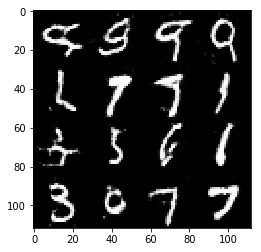

Epoch 2/2... Discriminator Loss: 1.4898... Generator Loss: 0.4699
Epoch 2/2... Discriminator Loss: 1.8883... Generator Loss: 0.2670
Epoch 2/2... Discriminator Loss: 1.2601... Generator Loss: 0.8802
Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 1.2979
Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 0.9401
Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.5490... Generator Loss: 0.4186
Epoch 2/2... Discriminator Loss: 1.0814... Generator Loss: 0.7938
Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 1.3818
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.7130


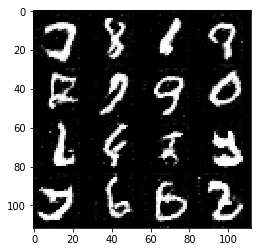

Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.6028... Generator Loss: 0.3894
Epoch 2/2... Discriminator Loss: 1.4584... Generator Loss: 0.5963
Epoch 2/2... Discriminator Loss: 1.6360... Generator Loss: 1.2836
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.7893
Epoch 2/2... Discriminator Loss: 1.5291... Generator Loss: 0.4575
Epoch 2/2... Discriminator Loss: 1.5360... Generator Loss: 0.4263
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.5920
Epoch 2/2... Discriminator Loss: 1.6450... Generator Loss: 0.3733
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 1.0384


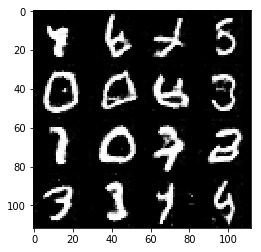

Epoch 2/2... Discriminator Loss: 1.4908... Generator Loss: 0.4979
Epoch 2/2... Discriminator Loss: 1.8213... Generator Loss: 0.3229
Epoch 2/2... Discriminator Loss: 1.5105... Generator Loss: 0.4438
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.6144
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 1.4187... Generator Loss: 0.5348
Epoch 2/2... Discriminator Loss: 1.3895... Generator Loss: 0.5893
Epoch 2/2... Discriminator Loss: 1.6620... Generator Loss: 0.3694
Epoch 2/2... Discriminator Loss: 1.6616... Generator Loss: 0.3747
Epoch 2/2... Discriminator Loss: 1.5177... Generator Loss: 0.4392


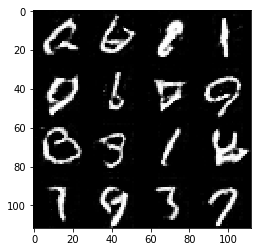

Epoch 2/2... Discriminator Loss: 1.3238... Generator Loss: 0.6731
Epoch 2/2... Discriminator Loss: 1.5646... Generator Loss: 0.4899
Epoch 2/2... Discriminator Loss: 1.3062... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 0.5592
Epoch 2/2... Discriminator Loss: 1.4863... Generator Loss: 0.4887
Epoch 2/2... Discriminator Loss: 2.1259... Generator Loss: 0.2424
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 1.2548... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 1.8895... Generator Loss: 0.2989


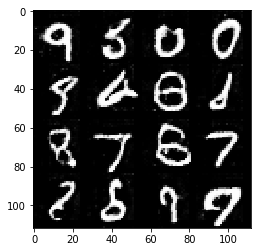

Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 0.7174
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.5299
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.5788
Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 0.9437
Epoch 2/2... Discriminator Loss: 1.5647... Generator Loss: 0.4568
Epoch 2/2... Discriminator Loss: 1.5948... Generator Loss: 0.4009
Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 0.8584
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.5060
Epoch 2/2... Discriminator Loss: 1.6145... Generator Loss: 0.4247
Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.4792


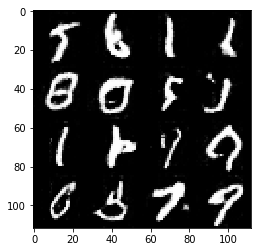

Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.5932
Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.5487
Epoch 2/2... Discriminator Loss: 1.4933... Generator Loss: 0.4763
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.6071
Epoch 2/2... Discriminator Loss: 1.5862... Generator Loss: 0.4183
Epoch 2/2... Discriminator Loss: 1.5736... Generator Loss: 0.4393


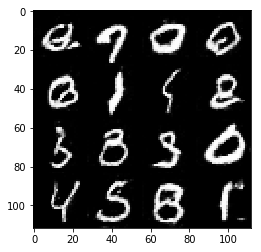

Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 0.9652
Epoch 2/2... Discriminator Loss: 1.4091... Generator Loss: 0.5544
Epoch 2/2... Discriminator Loss: 1.4649... Generator Loss: 0.4774
Epoch 2/2... Discriminator Loss: 1.6006... Generator Loss: 0.3964
Epoch 2/2... Discriminator Loss: 1.3360... Generator Loss: 0.5245
Epoch 2/2... Discriminator Loss: 1.6386... Generator Loss: 0.3865
Epoch 2/2... Discriminator Loss: 1.5142... Generator Loss: 0.4915
Epoch 2/2... Discriminator Loss: 1.5073... Generator Loss: 0.4443
Epoch 2/2... Discriminator Loss: 1.4897... Generator Loss: 0.4701
Epoch 2/2... Discriminator Loss: 2.9902... Generator Loss: 2.0230


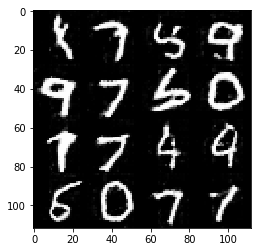

Epoch 2/2... Discriminator Loss: 1.5530... Generator Loss: 0.4533
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.6924
Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 0.6831
Epoch 2/2... Discriminator Loss: 1.6000... Generator Loss: 0.3987
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 0.4738
Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 0.6333
Epoch 2/2... Discriminator Loss: 1.0198... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.5557
Epoch 2/2... Discriminator Loss: 1.5343... Generator Loss: 0.4350
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.5716


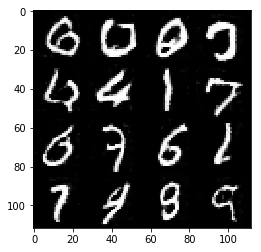

Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 0.6308
Epoch 2/2... Discriminator Loss: 1.1978... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.6952... Generator Loss: 0.4874
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.5394
Epoch 2/2... Discriminator Loss: 1.1614... Generator Loss: 0.7440
Epoch 2/2... Discriminator Loss: 1.5389... Generator Loss: 0.4388
Epoch 2/2... Discriminator Loss: 1.3519... Generator Loss: 0.5291
Epoch 2/2... Discriminator Loss: 1.4810... Generator Loss: 0.4623
Epoch 2/2... Discriminator Loss: 1.2135... Generator Loss: 1.0326
Epoch 2/2... Discriminator Loss: 1.7810... Generator Loss: 0.3409


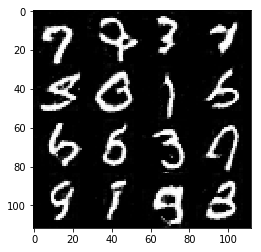

Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.5238
Epoch 2/2... Discriminator Loss: 1.4708... Generator Loss: 0.4766
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 0.7339
Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 0.5211
Epoch 2/2... Discriminator Loss: 1.7179... Generator Loss: 0.3513
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.6606
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.4977... Generator Loss: 0.4798
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.4447


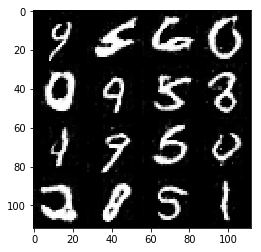

Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.5009
Epoch 2/2... Discriminator Loss: 1.4327... Generator Loss: 0.4891
Epoch 2/2... Discriminator Loss: 1.4082... Generator Loss: 0.7806
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 0.6418
Epoch 2/2... Discriminator Loss: 1.7575... Generator Loss: 0.3143
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 0.6882
Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.7312
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.6165


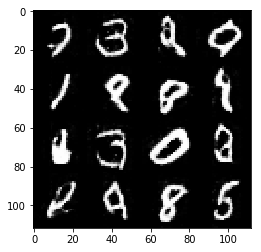

Epoch 2/2... Discriminator Loss: 1.5921... Generator Loss: 0.6397
Epoch 2/2... Discriminator Loss: 1.1650... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.5191
Epoch 2/2... Discriminator Loss: 1.4295... Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 0.7533
Epoch 2/2... Discriminator Loss: 1.5320... Generator Loss: 0.4572
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.6389
Epoch 2/2... Discriminator Loss: 1.2129... Generator Loss: 1.0600
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.5323
Epoch 2/2... Discriminator Loss: 1.4819... Generator Loss: 0.5631


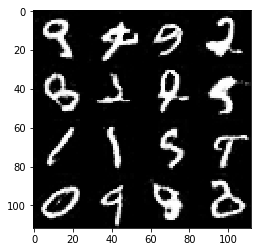

Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.5425
Epoch 2/2... Discriminator Loss: 1.6435... Generator Loss: 0.3822
Epoch 2/2... Discriminator Loss: 1.5490... Generator Loss: 0.4430
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.5409
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.3727... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.9529... Generator Loss: 0.2681
Epoch 2/2... Discriminator Loss: 1.4717... Generator Loss: 0.9393
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.5686


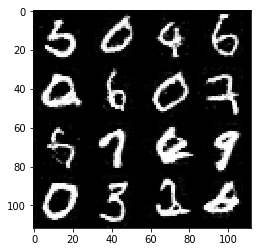

Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.6380
Epoch 2/2... Discriminator Loss: 1.6802... Generator Loss: 0.3651
Epoch 2/2... Discriminator Loss: 1.1166... Generator Loss: 0.9843
Epoch 2/2... Discriminator Loss: 1.4446... Generator Loss: 0.5810
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.6065
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.6907
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 1.9545... Generator Loss: 0.2700
Epoch 2/2... Discriminator Loss: 1.5314... Generator Loss: 0.5480
Epoch 2/2... Discriminator Loss: 1.8603... Generator Loss: 0.3108


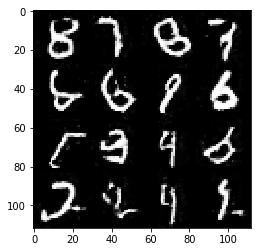

Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 1.0658
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 0.6859
Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 0.6211
Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 1.4094... Generator Loss: 0.5463
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.3560... Generator Loss: 0.5941
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.5600
Epoch 2/2... Discriminator Loss: 1.6345... Generator Loss: 0.3951
Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.5064


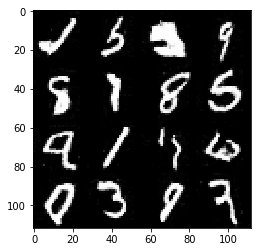

Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.5380
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.5269
Epoch 2/2... Discriminator Loss: 1.4098... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 0.5886
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.7247
Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 0.8185


In [12]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.4509... Generator Loss: 0.0204
Epoch 1/1... Discriminator Loss: 3.9316... Generator Loss: 0.0365
Epoch 1/1... Discriminator Loss: 3.3861... Generator Loss: 0.0656
Epoch 1/1... Discriminator Loss: 2.6297... Generator Loss: 0.1373
Epoch 1/1... Discriminator Loss: 2.7107... Generator Loss: 0.1781
Epoch 1/1... Discriminator Loss: 1.9584... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 2.2133... Generator Loss: 0.2344
Epoch 1/1... Discriminator Loss: 2.0401... Generator Loss: 0.3316
Epoch 1/1... Discriminator Loss: 2.0840... Generator Loss: 0.3473


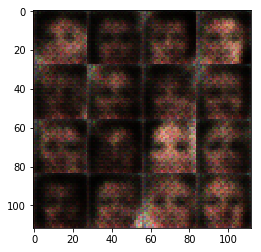

Epoch 1/1... Discriminator Loss: 1.9903... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 1.9091... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 1.9044... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 1.8557... Generator Loss: 0.4307
Epoch 1/1... Discriminator Loss: 1.7217... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.8891... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 1.8321... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.8162... Generator Loss: 0.4160
Epoch 1/1... Discriminator Loss: 1.7955... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.9003... Generator Loss: 0.4580


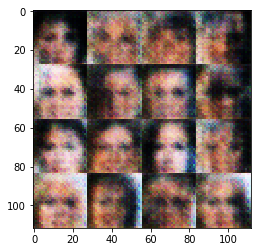

Epoch 1/1... Discriminator Loss: 1.8221... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.8252... Generator Loss: 0.3873
Epoch 1/1... Discriminator Loss: 1.6917... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.6439... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.8432... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 1.6854... Generator Loss: 0.4172
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 0.4245
Epoch 1/1... Discriminator Loss: 1.7840... Generator Loss: 0.4239


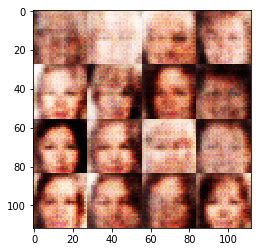

Epoch 1/1... Discriminator Loss: 1.8309... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.9385... Generator Loss: 0.3532
Epoch 1/1... Discriminator Loss: 1.6084... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.7765... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.8852... Generator Loss: 0.4151
Epoch 1/1... Discriminator Loss: 1.6946... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 2.0929... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.7473... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.5601


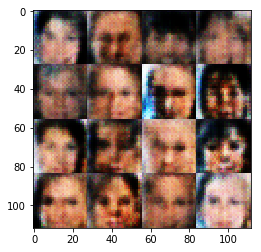

Epoch 1/1... Discriminator Loss: 1.7533... Generator Loss: 0.4551
Epoch 1/1... Discriminator Loss: 1.6602... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.7311... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.6670... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.7487... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 1.7625... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.7486... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.7411... Generator Loss: 0.5539


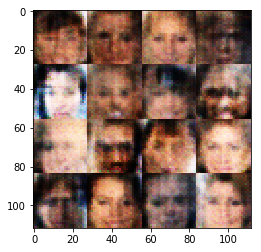

Epoch 1/1... Discriminator Loss: 1.7663... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.6551... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.6638... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.6184... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.6629... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.6672... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.6606... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.7704... Generator Loss: 0.4500


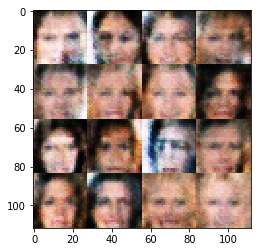

Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.7536... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.6182... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.5694


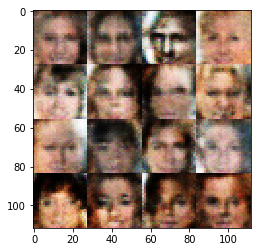

Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.5554... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7748


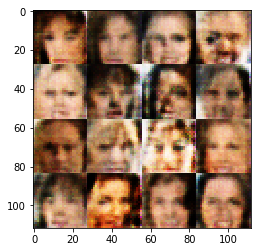

Epoch 1/1... Discriminator Loss: 1.6481... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.6551... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.6838


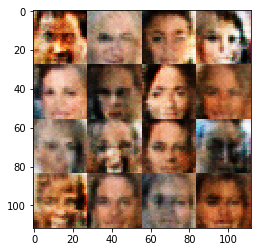

Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.7530... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.6031


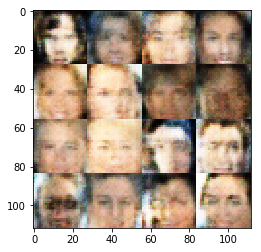

Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.6580... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.6768... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.6387... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.5912


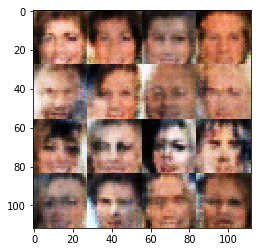

Epoch 1/1... Discriminator Loss: 1.5785... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.6856... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6661


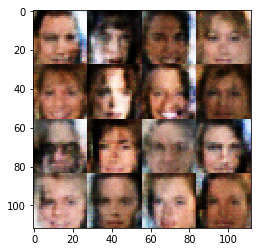

Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.6409


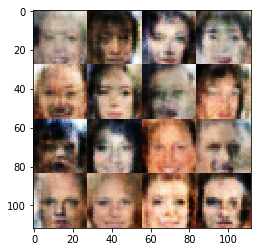

Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.7235... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.6174... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.6556... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.6943... Generator Loss: 0.5323


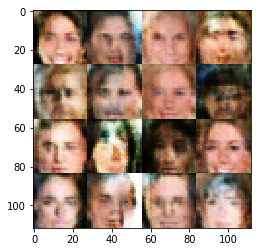

Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.5842... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.6298


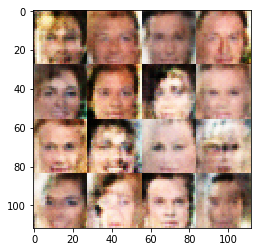

Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.6231


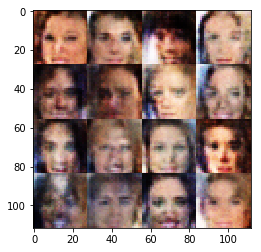

Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.6270... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.5547


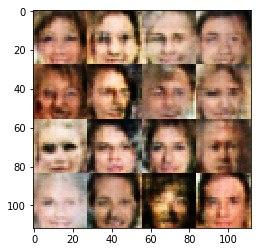

Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.6112... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.6227


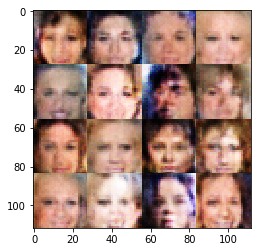

Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.6348


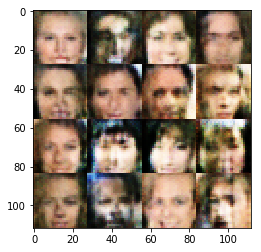

Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6906


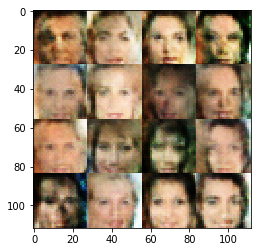

Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6861


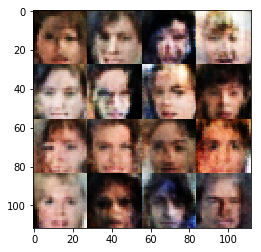

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.6445


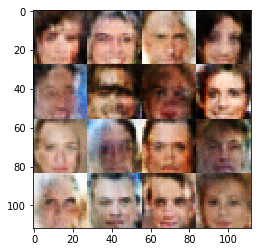

Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.6638


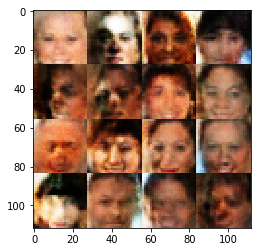

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.6492


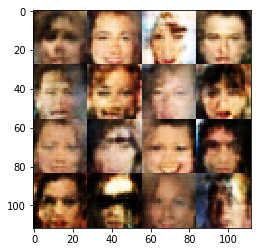

Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.6171


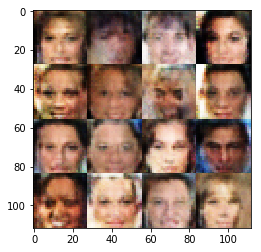

Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.6215


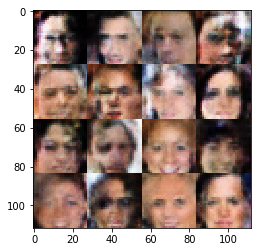

Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.6050... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7219


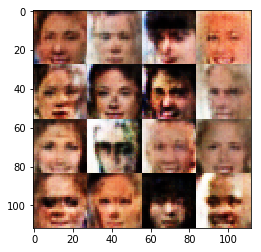

Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6473


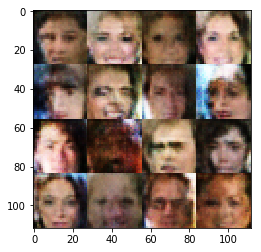

Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.5791... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6693


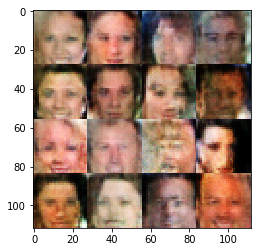

Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.6386... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.6722


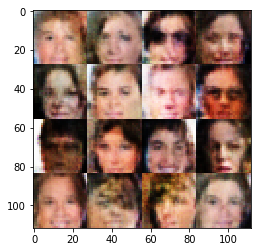

Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.6487


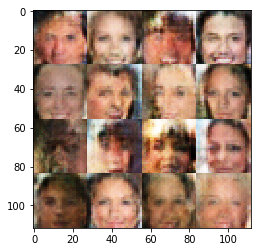

Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.5728


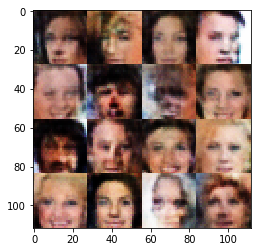

Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.6423


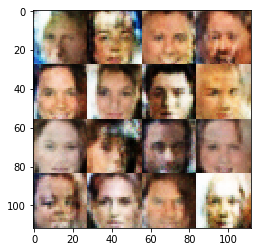

Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.5838


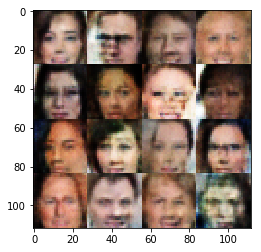

Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.6181


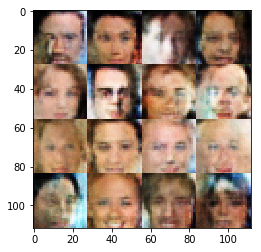

Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.6256... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6466


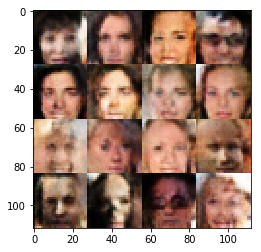

Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6901


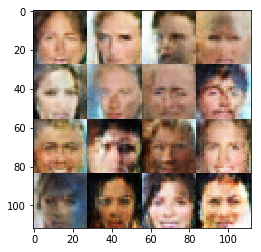

Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7142


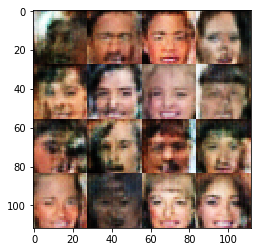

Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6704


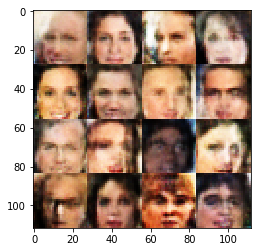

Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6911


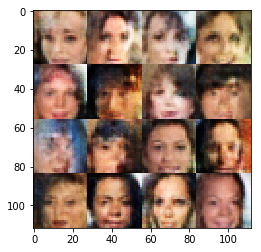

Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.6764


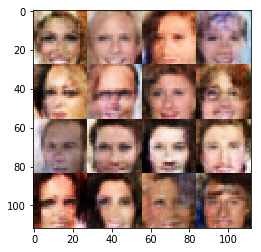

Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6901


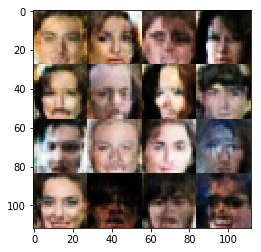

Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6534


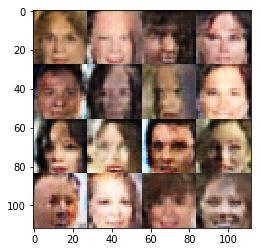

Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7209


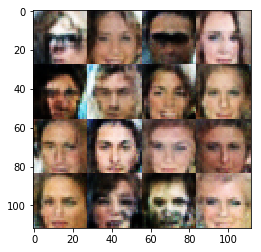

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.5853... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.6466


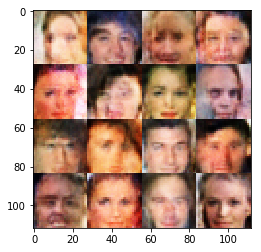

Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6618


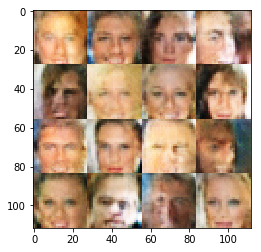

Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.7157


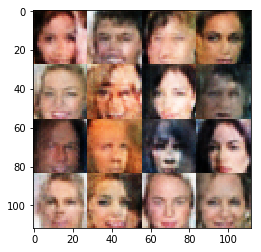

Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6930


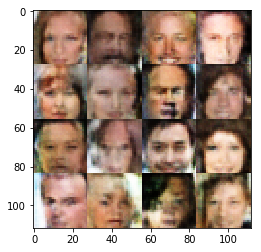

Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7216


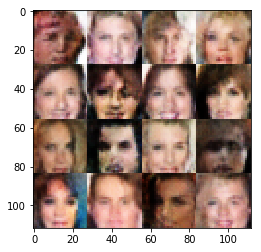

Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.6572


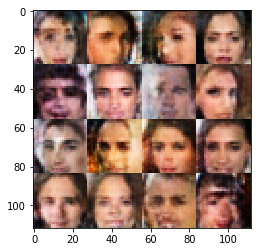

Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.6956


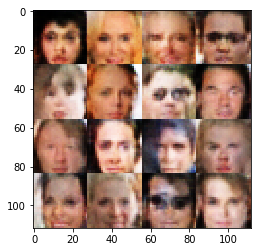

Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6812


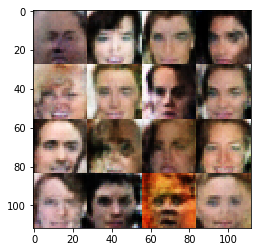

Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.6907


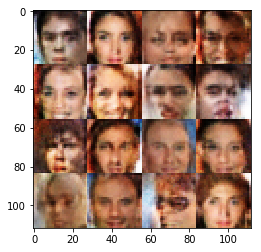

Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.6285


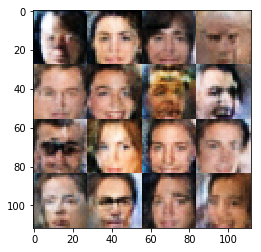

Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.6552


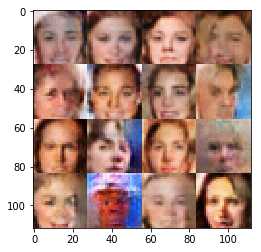

Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7102


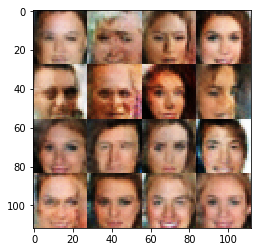

Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6553


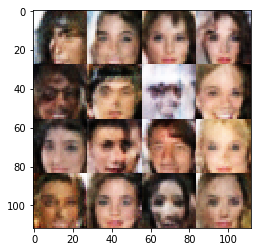

Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.6502


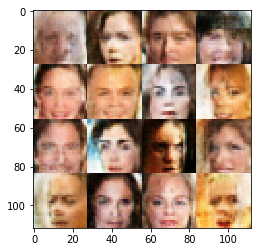

Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.5669... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6631


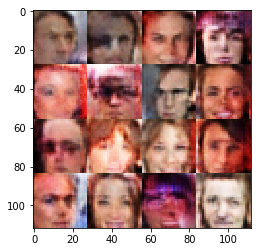

Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7130


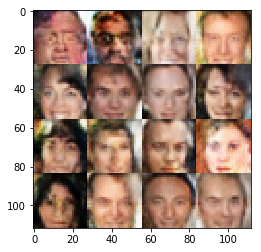

Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6403


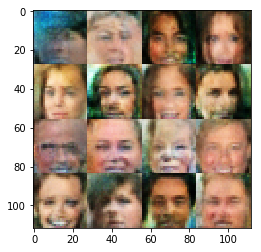

Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6502


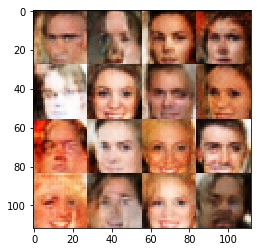

Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7074


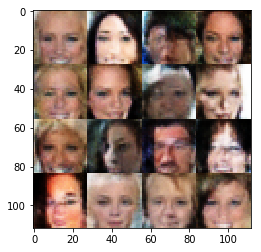

Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.6121


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.